## For Activation Func

## Sigmoid

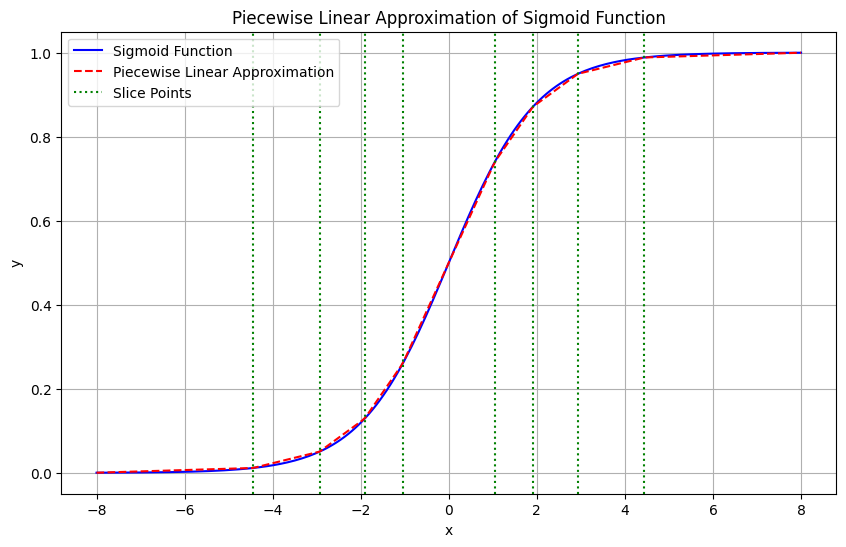

Optimal slice points: [-4.44276609 -2.93410561 -1.91285689 -1.04369786  1.04370402  1.91289759
  2.93408826  4.44283306]
Segment 1: x in [-8.00, -4.44] -> Slope: 0.0032, Intercept: 0.0257
Segment 2: x in [-4.44, -2.93] -> Slope: 0.0258, Intercept: 0.1261
Segment 3: x in [-2.93, -1.91] -> Slope: 0.0765, Intercept: 0.2751
Segment 4: x in [-1.91, -1.04] -> Slope: 0.1516, Intercept: 0.4187
Segment 5: x in [-1.04, 1.04] -> Slope: 0.2295, Intercept: 0.5000
Segment 6: x in [1.04, 1.91] -> Slope: 0.1516, Intercept: 0.5813
Segment 7: x in [1.91, 2.93] -> Slope: 0.0765, Intercept: 0.7249
Segment 8: x in [2.93, 4.44] -> Slope: 0.0258, Intercept: 0.8739
Segment 9: x in [4.44, 8.00] -> Slope: 0.0032, Intercept: 0.9743
KODE BINER
Optimal slice points: ['100000100011100010101100', '100000010111011110010000', '100000001111010011011000', '100000001000010110010111', '000000001000010110011000', '000000001111010011011001', '000000010111011110010000', '000000100011100010101110']
wire [BITSIZE-1:0] m1 = 24'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def binary24_to_float(binary_str):
    if (len(binary_str) < 24):
        binary_str = binary_str.zfill(24)
    elif (len(binary_str) > 24):
        binary_str = binary_str[-24:]
    
    for i in range(24):
        # print(binary_str[i])
        if binary_str[i] not in ('0', '1'):
            if (binary_str[i] == 'b'):
                binary_str = binary_str[i+1:]
                # print("trig")
                break
            else:
                print(f"Character at index {i} is neither '0' nor '1': {binary_str[i]}")
                return 0
    
    if (len(binary_str) < 24):
        binary_str = binary_str.zfill(24)
    print(binary_str)


    """Convert a 24-bit binary string to a float."""
    sign = int(binary_str[0])
    integer_part = int(binary_str[1:9], 2)
    fractional_part = binary_str[9:]
    frac_value = 0.0
    for i, bit in enumerate(fractional_part):
        if bit == '1':
            frac_value += 1 / (2 ** (i + 1))
    float_value = integer_part + frac_value
    if sign == 1:
        float_value = -float_value
    return float_value


def float_to_custom_binary(float_value):
    # Determine the sign bit
    sign_bit = 0 if float_value >= 0 else 1

    # Get the absolute value of the float for further processing
    abs_value = abs(float_value)

    # Separate the integer and fractional parts
    integer_part = int(abs_value)
    fractional_part = abs_value - integer_part

    # Convert the integer part to binary (4 bits)
    integer_binary = format(integer_part & 0b11111111, '08b')

    # Convert the fractional part to binary (27 bits)
    fractional_binary = ''
    for _ in range(15):
        fractional_part *= 2
        bit = int(fractional_part)
        fractional_binary += str(bit)
        fractional_part -= bit

    # Combine all parts into a single binary string
    custom_binary = f"{sign_bit}{integer_binary}{fractional_binary}"

    return custom_binary

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the piecewise linear function
def piecewise_linear(x, slice_points):
    # Sort slice points
    slice_points = np.sort(slice_points)
    segments = []
    y = np.zeros_like(x)

    # Handle the segment from the left endpoint to the first slice point
    x1 = slice_points[0]
    y1 = sigmoid(x1)
    slope = (y1 - sigmoid(x[0])) / (x1 - x[0]) if x[0] < x1 else 0
    intercept = sigmoid(x[0]) - slope * x[0]
    segments.append((slope, intercept, x[0], x1))
    
    # Evaluate the first segment
    mask = (x >= x[0]) & (x < x1)
    y[mask] = slope * x[mask] + intercept

    # Iterate through slice points to create segments
    for i in range(len(slice_points) - 1):
        x1, x2 = slice_points[i], slice_points[i + 1]
        y1, y2 = sigmoid(x1), sigmoid(x2)
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        segments.append((slope, intercept, x1, x2))

        # Evaluate piecewise linear segments
        mask = (x >= x1) & (x < x2)
        y[mask] = slope * x[mask] + intercept

    # Handle the segment from the last slice point to the right endpoint
    x1 = slice_points[-1]
    y1 = sigmoid(x1)
    slope = (sigmoid(x[-1]) - y1) / (x[-1] - x1) if x[-1] > x1 else 0
    intercept = y1 - slope * x1
    segments.append((slope, intercept, x1, x[-1]))

    # Evaluate the last segment
    mask = (x >= x1)
    y[mask] = slope * x[mask] + intercept

    return y, segments

# Define the error function to minimize
def error_function(slice_points, x, y):
    y_approx, _ = piecewise_linear(x, slice_points)
    return np.mean((y - y_approx) ** 2)

# Main function to find optimal slice points
def find_optimal_slices(num_slices, x_range):
    # Generate x values
    x = np.linspace(x_range[0], x_range[1], 100)
    y = sigmoid(x)

    # Initial guess for slice points
    initial_slices = np.linspace(x_range[0], x_range[1], num_slices)

    # Optimize slice points
    result = minimize(error_function, initial_slices, args=(x, y), method='Nelder-Mead')
    
    optimal_slices = np.sort(result.x)
    return optimal_slices

# Parameters
num_slices = 8
x_range = (-8, 8)

# Find optimal slice points
optimal_slices = find_optimal_slices(num_slices, x_range)

# Generate x values and sigmoid function for plotting
x_values = np.linspace(x_range[0], x_range[1], 200)
sigmoid_values = sigmoid(x_values)
piecewise_values, segments = piecewise_linear(x_values, optimal_slices)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, sigmoid_values, label='Sigmoid Function', color='blue')
plt.plot(x_values, piecewise_values, label='Piecewise Linear Approximation', color='red', linestyle='--')
plt.axvline(x=optimal_slices[0], color='green', linestyle=':', label='Slice Points')
plt.axvline(x=optimal_slices[-1], color='green', linestyle=':')
for point in optimal_slices[1:-1]:
    plt.axvline(x=point, color='green', linestyle=':')
plt.title('Piecewise Linear Approximation of Sigmoid Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Print optimal slice points and corresponding slopes and intercepts
print("Optimal slice points:", optimal_slices)
for i in range(len(segments)):
 slope, intercept, x1, x2 = segments[i]
 print(f"Segment {i + 1}: x in [{x1:.2f}, {x2:.2f}] -> Slope: {slope:.4f}, Intercept: {intercept:.4f}")

# Print optimal slice points and corresponding slopes and intercepts in custom binary format
print("KODE BINER")
print("Optimal slice points:", [float_to_custom_binary(x) for x in optimal_slices])
for i in range(len(segments)):
    slope, intercept, x1, x2 = segments[i]
    slope_binary = float_to_custom_binary(slope)
    intercept_binary = float_to_custom_binary(intercept)
    # print(f"Segment {i + 1}: x in [{x1:.2f}, {x2:.2f}] -> Slope: 20'b{slope_binary}, Intercept: 20'b{intercept_binary}")
    print(f"wire [BITSIZE-1:0] m{i+1} = 24'b{float_to_custom_binary(slope)}; // m{i+1} = {slope}")
    print(f"wire [BITSIZE-1:0] c{i+1} = 24'b{float_to_custom_binary(intercept)}; // c{i+1} = {intercept}")
    print()

for i in range(len(optimal_slices)):
    print(f"wire [BITSIZE-1:0] x{i+1} = 24'b{float_to_custom_binary(optimal_slices[i])}; // x{i+1} = {optimal_slices[i]}")

## Revamp softplus
### Menghasilkan slope dan intercept di antara range juga

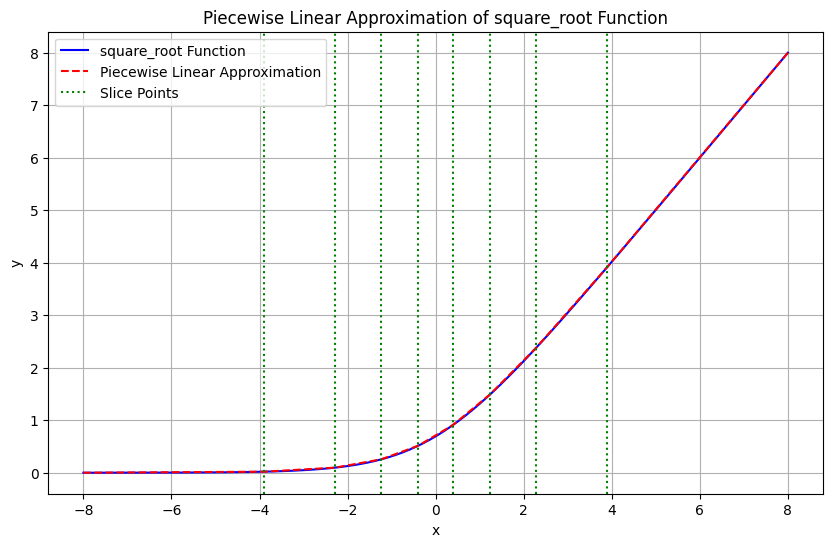

Optimal slice points: [-3.89013809 -2.27923567 -1.2334574  -0.39581795  0.39366939  1.23075987
  2.28332082  3.88963558]
Segment 1: x in [-8.00, -3.89] -> Slope: 0.0048, Intercept: 0.0391
Segment 2: x in [-3.89, -2.28] -> Slope: 0.0479, Intercept: 0.2067
Segment 3: x in [-2.28, -1.23] -> Slope: 0.1513, Intercept: 0.4422
Segment 4: x in [-1.23, -0.40] -> Slope: 0.3093, Intercept: 0.6371
Segment 5: x in [-0.40, 0.39] -> Slope: 0.4997, Intercept: 0.7125
Segment 6: x in [0.39, 1.23] -> Slope: 0.6902, Intercept: 0.6375
Segment 7: x in [1.23, 2.28] -> Slope: 0.8488, Intercept: 0.4424
Segment 8: x in [2.28, 3.89] -> Slope: 0.9522, Intercept: 0.2063
Segment 9: x in [3.89, 8.00] -> Slope: 0.9952, Intercept: 0.0391
KODE BINER
Optimal slice points: ['100000011111000111110000', '100000010010001110111101', '100000001001110111100001', '100000000011001010101010', '000000000011001001100011', '000000001001110110001001', '000000010010010001000011', '000000011111000111011111']
reg [BITSIZE-1:0] m1 = 24'b

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def binary24_to_float(binary_str):
    if (len(binary_str) < 24):
        binary_str = binary_str.zfill(24)
    elif (len(binary_str) > 24):
        binary_str = binary_str[-24:]
    
    for i in range(24):
        # print(binary_str[i])
        if binary_str[i] not in ('0', '1'):
            if (binary_str[i] == 'b'):
                binary_str = binary_str[i+1:]
                # print("trig")
                break
            else:
                print(f"Character at index {i} is neither '0' nor '1': {binary_str[i]}")
                return 0
    
    if (len(binary_str) < 24):
        binary_str = binary_str.zfill(24)
    print(binary_str)


    """Convert a 24-bit binary string to a float."""
    sign = int(binary_str[0])
    integer_part = int(binary_str[1:9], 2)
    fractional_part = binary_str[9:]
    frac_value = 0.0
    for i, bit in enumerate(fractional_part):
        if bit == '1':
            frac_value += 1 / (2 ** (i + 1))
    float_value = integer_part + frac_value
    if sign == 1:
        float_value = -float_value
    return float_value


def float_to_custom_binary(float_value):
    # Determine the sign bit
    sign_bit = 0 if float_value >= 0 else 1

    # Get the absolute value of the float for further processing
    abs_value = abs(float_value)

    # Separate the integer and fractional parts
    integer_part = int(abs_value)
    fractional_part = abs_value - integer_part

    # Convert the integer part to binary (4 bits)
    integer_binary = format(integer_part & 0b11111111, '08b')

    # Convert the fractional part to binary (27 bits)
    fractional_binary = ''
    for _ in range(15):
        fractional_part *= 2
        bit = int(fractional_part)
        fractional_binary += str(bit)
        fractional_part -= bit

    # Combine all parts into a single binary string
    custom_binary = f"{sign_bit}{integer_binary}{fractional_binary}"

    return custom_binary

# Define the square_root function
def square_root(x):
    return np.log(1 + np.exp(x))

# Define the piecewise linear function
def piecewise_linear(x, slice_points):
    # Sort slice points
    slice_points = np.sort(slice_points)
    segments = []
    y = np.zeros_like(x)

    # Handle the segment from the left endpoint to the first slice point
    x1 = slice_points[0]
    y1 = square_root(x1)
    slope = (y1 - square_root(x[0])) / (x1 - x[0]) if x[0] < x1 else 0
    intercept = square_root(x[0]) - slope * x[0]
    segments.append((slope, intercept, x[0], x1))
    
    # Evaluate the first segment
    mask = (x >= x[0]) & (x < x1)
    y[mask] = slope * x[mask] + intercept

    # Iterate through slice points to create segments
    for i in range(len(slice_points) - 1):
        x1, x2 = slice_points[i], slice_points[i + 1]
        y1, y2 = square_root(x1), square_root(x2)
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        segments.append((slope, intercept, x1, x2))

        # Evaluate piecewise linear segments
        mask = (x >= x1) & (x < x2)
        y[mask] = slope * x[mask] + intercept

    # Handle the segment from the last slice point to the right endpoint
    x1 = slice_points[-1]
    y1 = square_root(x1)
    slope = (square_root(x[-1]) - y1) / (x[-1] - x1) if x[-1] > x1 else 0
    intercept = y1 - slope * x1
    segments.append((slope, intercept, x1, x[-1]))

    # Evaluate the last segment
    mask = (x >= x1)
    y[mask] = slope * x[mask] + intercept

    return y, segments

# Define the error function to minimize
def error_function(slice_points, x, y):
    y_approx, _ = piecewise_linear(x, slice_points)
    return np.mean((y - y_approx) ** 2)

# Main function to find optimal slice points
def find_optimal_slices(num_slices, x_range):
    # Generate x values
    x = np.linspace(x_range[0], x_range[1], 100)
    y = square_root(x)

    # Initial guess for slice points
    initial_slices = np.linspace(x_range[0], x_range[1], num_slices)

    # Define bounds for the slice points to ensure they remain within the range
    bounds = [(x_range[0], x_range[1]) for _ in range(num_slices)]

    # Optimize slice points
    result = minimize(error_function, initial_slices, args=(x, y), bounds=bounds, method='L-BFGS-B')
    
    optimal_slices = np.sort(result.x)
    return optimal_slices

# Parameters
num_slices = 8
x_range = (-8, 8)

# Find optimal slice points
optimal_slices = find_optimal_slices(num_slices, x_range)

# Generate x values and square_root function for plotting
x_values = np.linspace(x_range[0], x_range[1], 200)
square_root_values = square_root(x_values)
piecewise_values, segments = piecewise_linear(x_values, optimal_slices)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, square_root_values, label='square_root Function', color='blue')
plt.plot(x_values, piecewise_values, label='Piecewise Linear Approximation', color='red', linestyle='--')
plt.axvline(x=optimal_slices[0], color='green', linestyle=':', label='Slice Points')
plt.axvline(x=optimal_slices[-1], color='green', linestyle=':')
for point in optimal_slices[1:-1]:
    plt.axvline(x=point, color='green', linestyle=':')
plt.title('Piecewise Linear Approximation of square_root Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Print optimal slice points and corresponding slopes and intercepts
print("Optimal slice points:", optimal_slices)
for i in range(len(segments)):
    slope, intercept, x1, x2 = segments[i]
    print(f"Segment {i + 1}: x in [{x1:.2f}, {x2:.2f}] -> Slope: {slope:.4f}, Intercept: {intercept:.4f}")

# Print optimal slice points and corresponding slopes and intercepts in custom binary format
print("KODE BINER")
print("Optimal slice points:", [float_to_custom_binary(x) for x in optimal_slices])
for i in range(len(segments)):
    slope, intercept, x1, x2 = segments[i]
    # slope_binary = float_to_custom_binary(slope)
    # intercept_binary = float_to_custom_binary(intercept)
    # print(f"Segment {i + 1}: x in [{x1:.2f}, {x2:.2f}] -> Slope: {slope_binary}, Intercept: {intercept_binary}")
    print(f"reg [BITSIZE-1:0] m{i+1} = 24'b{float_to_custom_binary(slope)}; // m{i+1} = {slope}")
    print(f"reg [BITSIZE-1:0] c{i+1} = 24'b{float_to_custom_binary(intercept)}; // c{i+1} = {intercept}")
    print()

for i in range(len(optimal_slices)):
    print(f"reg [BITSIZE-1:0] x{i+1} = 24'b{float_to_custom_binary(optimal_slices[i])}; // x{i+1} = {optimal_slices[i]}")

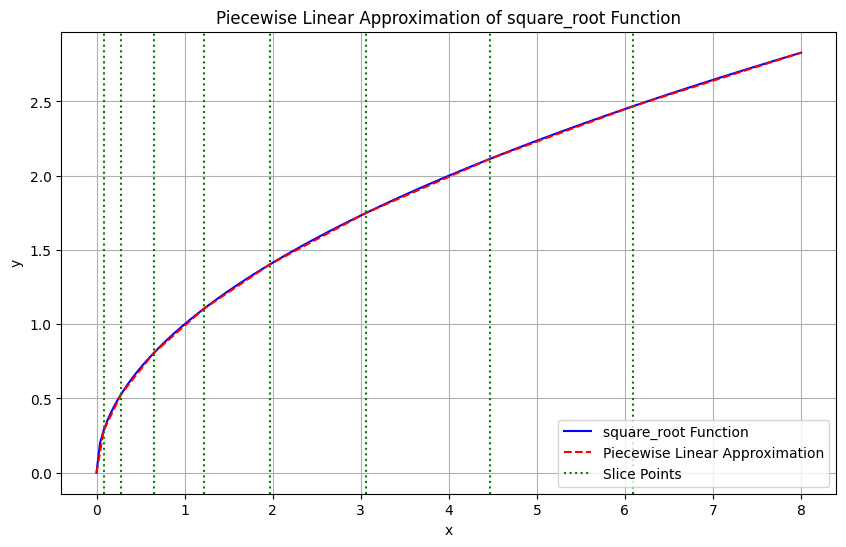

Optimal slice points: [0.0832509  0.28315796 0.64933825 1.21499166 1.97507676 3.06031068
 4.46459428 6.08952768]
Segment 1: x in [0.00, 0.08] -> Slope: 3.4658, Intercept: 0.0000
Segment 2: x in [0.08, 0.28] -> Slope: 1.2185, Intercept: 0.1871
Segment 3: x in [0.28, 0.65] -> Slope: 0.7474, Intercept: 0.3205
Segment 4: x in [0.65, 1.21] -> Slope: 0.5241, Intercept: 0.4655
Segment 5: x in [1.21, 1.98] -> Slope: 0.3988, Intercept: 0.6178
Segment 6: x in [1.98, 3.06] -> Slope: 0.3170, Intercept: 0.7793
Segment 7: x in [3.06, 4.46] -> Slope: 0.2589, Intercept: 0.9570
Segment 8: x in [4.46, 6.09] -> Slope: 0.2183, Intercept: 1.1383
Segment 9: x in [6.09, 8.00] -> Slope: 0.1888, Intercept: 1.3179
KODE BINER
Optimal slice points: ['000000000000101010100111', '000000000010010000111110', '000000000101001100011101', '000000001001101110000100', '000000001111110011001111', '000000011000011110111000', '000000100011101101110111', '000000110000101101110101']
wire [BITSIZE-1:0] m1 = 24'b0000000110111011

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def binary24_to_float(binary_str):
    if (len(binary_str) < 24):
        binary_str = binary_str.zfill(24)
    elif (len(binary_str) > 24):
        binary_str = binary_str[-24:]
    
    for i in range(24):
        # print(binary_str[i])
        if binary_str[i] not in ('0', '1'):
            if (binary_str[i] == 'b'):
                binary_str = binary_str[i+1:]
                # print("trig")
                break
            else:
                print(f"Character at index {i} is neither '0' nor '1': {binary_str[i]}")
                return 0
    
    if (len(binary_str) < 24):
        binary_str = binary_str.zfill(24)
    print(binary_str)


    """Convert a 24-bit binary string to a float."""
    sign = int(binary_str[0])
    integer_part = int(binary_str[1:9], 2)
    fractional_part = binary_str[9:]
    frac_value = 0.0
    for i, bit in enumerate(fractional_part):
        if bit == '1':
            frac_value += 1 / (2 ** (i + 1))
    float_value = integer_part + frac_value
    if sign == 1:
        float_value = -float_value
    return float_value


def float_to_custom_binary(float_value):
    # Determine the sign bit
    sign_bit = 0 if float_value >= 0 else 1

    # Get the absolute value of the float for further processing
    abs_value = abs(float_value)

    # Separate the integer and fractional parts
    integer_part = int(abs_value)
    fractional_part = abs_value - integer_part

    # Convert the integer part to binary (4 bits)
    integer_binary = format(integer_part & 0b11111111, '08b')

    # Convert the fractional part to binary (27 bits)
    fractional_binary = ''
    for _ in range(15):
        fractional_part *= 2
        bit = int(fractional_part)
        fractional_binary += str(bit)
        fractional_part -= bit

    # Combine all parts into a single binary string
    custom_binary = f"{sign_bit}{integer_binary}{fractional_binary}"

    return custom_binary

# Define the square root function
def square_root(x):
    return np.sqrt(x)


# Define the piecewise linear function
def piecewise_linear(x, slice_points):
    # Sort slice points
    slice_points = np.sort(slice_points)
    segments = []
    y = np.zeros_like(x)

    # Handle the segment from the left endpoint to the first slice point
    x1 = slice_points[0]
    y1 = square_root(x1)
    slope = (y1 - square_root(x[0])) / (x1 - x[0]) if x[0] < x1 else 0
    intercept = square_root(x[0]) - slope * x[0]
    segments.append((slope, intercept, x[0], x1))
    
    # Evaluate the first segment
    mask = (x >= x[0]) & (x < x1)
    y[mask] = slope * x[mask] + intercept

    # Iterate through slice points to create segments
    for i in range(len(slice_points) - 1):
        x1, x2 = slice_points[i], slice_points[i + 1]
        y1, y2 = square_root(x1), square_root(x2)
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        segments.append((slope, intercept, x1, x2))

        # Evaluate piecewise linear segments
        mask = (x >= x1) & (x < x2)
        y[mask] = slope * x[mask] + intercept

    # Handle the segment from the last slice point to the right endpoint
    x1 = slice_points[-1]
    y1 = square_root(x1)
    slope = (square_root(x[-1]) - y1) / (x[-1] - x1) if x[-1] > x1 else 0
    intercept = y1 - slope * x1
    segments.append((slope, intercept, x1, x[-1]))

    # Evaluate the last segment
    mask = (x >= x1)
    y[mask] = slope * x[mask] + intercept

    return y, segments

# Define the error function to minimize
def error_function(slice_points, x, y):
    y_approx, _ = piecewise_linear(x, slice_points)
    return np.mean((y - y_approx) ** 2)

# Main function to find optimal slice points
def find_optimal_slices(num_slices, x_range):
    # Generate x values
    x = np.linspace(x_range[0], x_range[1], 100)
    y = square_root(x)

    # Initial guess for slice points
    initial_slices = np.linspace(x_range[0], x_range[1], num_slices)

    # Define bounds for the slice points to ensure they remain within the range
    bounds = [(x_range[0], x_range[1]) for _ in range(num_slices)]

    # Optimize slice points
    result = minimize(error_function, initial_slices, args=(x, y), bounds=bounds, method='L-BFGS-B')
    
    optimal_slices = np.sort(result.x)
    return optimal_slices

# Parameters
num_slices = 8
x_range = (0, 8)

# Find optimal slice points
optimal_slices = find_optimal_slices(num_slices, x_range)

# Generate x values and square_root function for plotting
x_values = np.linspace(x_range[0], x_range[1], 200)
square_root_values = square_root(x_values)
piecewise_values, segments = piecewise_linear(x_values, optimal_slices)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, square_root_values, label='square_root Function', color='blue')
plt.plot(x_values, piecewise_values, label='Piecewise Linear Approximation', color='red', linestyle='--')
plt.axvline(x=optimal_slices[0], color='green', linestyle=':', label='Slice Points')
plt.axvline(x=optimal_slices[-1], color='green', linestyle=':')
for point in optimal_slices[1:-1]:
    plt.axvline(x=point, color='green', linestyle=':')
plt.title('Piecewise Linear Approximation of square_root Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Print optimal slice points and corresponding slopes and intercepts
print("Optimal slice points:", optimal_slices)
for i in range(len(segments)):
    slope, intercept, x1, x2 = segments[i]
    print(f"Segment {i + 1}: x in [{x1:.2f}, {x2:.2f}] -> Slope: {slope:.4f}, Intercept: {intercept:.4f}")

# Print optimal slice points and corresponding slopes and intercepts in custom binary format
print("KODE BINER")
print("Optimal slice points:", [float_to_custom_binary(x) for x in optimal_slices])
for i in range(len(segments)):
    slope, intercept, x1, x2 = segments[i]
    # slope_binary = float_to_custom_binary(slope)
    # intercept_binary = float_to_custom_binary(intercept)
    # print(f"Segment {i + 1}: x in [{x1:.2f}, {x2:.2f}] -> Slope: {slope_binary}, Intercept: {intercept_binary}")
    print(f"wire [BITSIZE-1:0] m{i+1} = 24'b{float_to_custom_binary(slope)}; // m{i+1} = {slope}")
    print(f"wire [BITSIZE-1:0] c{i+1} = 24'b{float_to_custom_binary(intercept)}; // c{i+1} = {intercept}")
    print()

for i in range(len(optimal_slices)):
    print(f"wire [BITSIZE-1:0] x{i+1} = 24'b{float_to_custom_binary(optimal_slices[i])}; // x{i+1} = {optimal_slices[i]}")